# Project BBT045
Question:
> How pharmaceutical pollution affect microbial community composition

In [1]:
#Load modules
#??
#matplotlib
#seaborn?

# Temporary

In [4]:
# Directories
# groupDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/
# resultsDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/
# dataDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA


# Checking stuff, remove later

##Check that we have access to the files in the common directory:
#with open("/cephyr/NOBACKUP/groups/bbt045_2024/project_group1/filelist.txt") as f: # The with keyword automatically closes the file when you are done
#    print(f.read())
#    #ref https://stackoverflow.com/questions/18256363/how-do-i-print-the-content-of-a-txt-file-in-python

#Search for packages in the softwarelist
! grep "meta" < /cephyr/NOBACKUP/groups/bbt045_2024/ProjectSoftware/bbt045-projects.yml

# Display the files in the data directory
#!ls {dataDirectory}

# Check variable directory names
#!head {dataDirectory}/change_filenames_1.sh

  - importlib-metadata=7.0.1=py310h06a4308_0
  - importlib_metadata=7.0.1=hd3eb1b0_0
  - metaphlan=4.0.6=pyhca03a8a_0


In [5]:
%%bash
DATADIR=/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA;

# Test av loop och filsökning med *:
for file in `ls $DATADIR/*_1.fastq.gz  | grep -v "_lake_" | sed "s/_1.fastq.gz//"`
do
    echo $file
    #outputName=`echo $file | sed "s/\/cephyr\/NOBACKUP\/groups\/bbt045_2024\/PROJECT_DATA\///"`
    #echo $outputName
done

/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_1.5km_2012
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_17.5km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_2.3km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_2.7km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/effluent_point_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_1.9km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_150m_2012
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_2.2km_2011


# TO DO
- Text hur vi valde saker
- Text hur vi valde inställningar
- Referenser: manualer?
- Länk till script-filer? Fungerar det i Jupyter?
- Uppdatera text med hur scriptet körs?
- Ta bort onödiga kommentarer i kodrutorna
- Renskriv batchfilernas kommentarer
- Kopiera så att det finns två batchfiler för trim? 2012 vs 2011, se kommentarer
- Fixa rescaled values
- PCA plot i jupyter?
- Andra plots i jupyter? Barplots? Boxplots?
- Count species per sample?


# Quality control and trimming

## FastQC
Do FastQC for all samples except those with "lake" in their name. 

In [6]:
%%script false --no-raise-error
for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/*.fastq.gz | grep -v "_lake_"`
do
    fastqc $file -o /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/fastqc
done

#Tekniskt sett är det detta som körs:
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done

## Bash script for trimmomatic

The following sbatch script is to run trimmomatic on all samples except those with "_lake_" in their name

NOTE:
- Behövde använda -phred64 på 2011-filerna, gav error på dem annars när jag körde den. När ska köra 2012-filerna: byt ut år i `cp`och `-phred64` till `-phred33`

Paired End Mode:
ref: http://www.usadellab.org/cms/?page=trimmomatic
> trimmomatic PE [-threads <threads>] [-phred33 | -phred64] [-trimlog <logFile>] <input 1> <input 2> <paired output 1> <unpaired output 1> <paired output 2> <unpaired output 2> <step 1> ...

In [7]:
%%script false --no-raise-error
# Extra för min förståelse, ta bort?
WORKDIR=/cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/trimmomatic;
WORKING_TMP=$TMPDIR/TRIM_TMP;

mkdir $WORKING_TMP;
cd $WORKING_TMP;

cp /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/*2011*.fastq.gz $WORKING_TMP

### Running Trimmomatic
for file in `ls *_1.fastq.gz  | grep -v "_lake_" | sed "s/_1.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC trimmomatic PE -phred64 \
                    $file\_1.fastq.gz $file\_2.fastq.gz \
                    $file\_1.trimmed.fastq.gz $file\_1.un.trimmed.fastq.gz \
                    $file\_2.trimmed.fastq.gz $file\_2.un.trimmed.fastq.gz \
                    TOPHRED33 \
                    LEADING:30 TRAILING:30 \
                    MINLEN:60
done


# Extra, ta bort:
    #question: does this output the files in $WORKING_TMP? Or do we need to add this before the output file names?
            # or do we need to remove everything but the name and use that instead of $file as below?
    #question/look at output: autodetect phred score? (run one of each and see? 33 first)
    #question Paria/Alva: vilket score ska vi använda?
    #question: Need to remove adapters? Nearly no present?
    #question: trimmomatic phred score? TOPHRED64 if already PHRED64??

    #ls $file\_1.fastq.gz $file\_2.fastq.gz
    #apptainer exec $CONTAINER_LOC trim_galore --quality 20 --length 60 --cores 8 --paired -o /cephyr/NOBACKUP/groups/bbt045_2024/projectAliceRita5 $i\_1.fastq.gz $i\_2.fastq.gz

# Johan brukar altid trimma adapters innan uppladdning, kanske därför vi inte ser några i fastqc-output

# FastQC (again)
Körde fastqc igen, fast denna gång på alla filer i project_group1/results/trimmomatic/

In [9]:
%%script false --no-raise-error
for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/*.fastq.gz | grep -v "_lake_"`
do
    fastqc $file -o /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/fastqc
done

#Tekniskt sett är det detta som körs:
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done

# Metaphlan4

Running metaphlan4

Wiki: https://github.com/biobakery/biobakery/wiki/metaphlan4 

In [8]:
%%script false --no-raise-error
#run the following in a terminal in a new tab in jupyter:
metaphlan -h | less

In [10]:
%%script false --no-raise-error
for file in `ls *1.trimmed.fastq.gz | sed "s/_1.trimmed.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC metaphlan $file\_1.trimmed.fastq.gz,$file\_2.trimmed.fastq.gz \
                                            --input_type fastq --nproc 16 --unclassified_estimation --bowtie2out $file.bowtie2.bz2 -o $file\_profile.txt\
                                            
done

#From template from Vi:
for i in SRS*.fasta.gz; do metaphlan $i --input_type fasta --nproc 4 > ${i%.fasta.gz}_profile.txt; done

#todo Lägga till: ?
# --unclassified_estimation (kanske roligt att veta?)
# --add_viruses (eller inte eftersom det är microbial community, --> ≠ virus?)
#todo Kontrollera size av --bowtie2out $file.bowtie2.bz2 efter första testet, giganorm fil?
#todo: | grep -v ".un.trimmed.fastq.gz"| not needed if not copied over?
#todo: PCA från pandas dataframe?
"todo:"

## Visualizing metaphlan output

In [2]:
#%%script false --no-raise-error
# Merge the _profile tables for each sample into a single file
!merge_metaphlan_tables.py /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/metaphlan/*_profile.txt > merged_abundance_table.txt
#ref: https://github.com/biobakery/biobakery/wiki/metaphlan4#16-merging-metaphlan-profiles

# Isolate the species-resolved rows and then remove clutter 
!grep -E "s__|clade_name|UNCLASSIFIED" merged_abundance_table.txt |\
    grep -v "t__" |\
    sed "s/^.*|s__//g" |\
    sed "s/SRS[0-9]*-//g" \
    > merged_abundance_table_species.txt
#ref https://github.com/biobakery/biobakery/wiki/metaphlan4#211-generate-a-species-only-abundance-table

#remove s__ to keep it in the file, for specificity?
#todo förbättra kommentarer ovan, se ref:s för mer info

In [3]:
import pandas as pd
species_file = "merged_abundance_table_species.txt"
# Tab separated, first row column names, first column row names
species_df = pd.read_csv(species_file, sep='\t', header=0, index_col=0)

unclassified__proportion = species_df.iloc[0,0]
print("Unclassified proportion:", unclassified__proportion)

species_df.head(25)
print("\nSum of species + unclassified:\n", species_df.sum())

# Rescale all values:
test = (100-unclassified__proportion)/100
test_df = species_df/test
test_proportions = test_df.iloc[range(1, len(test_df-1)), 0].sum()
print("\nRescaled proportions sum, without unclassified:\n", test_proportions)

#test_df #View the rescaled proportions (comment out the other one)
species_df #View the species dataframe

#todo MERGE

Unclassified proportion: 92.6091

Sum of species + unclassified:
 downstream_1.5km_2012     100.000003
downstream_17.5km_2011    100.000003
downstream_2.3km_2011     100.000005
downstream_2.7km_2011     100.000000
effluent_point_2011        99.999996
upstream_1.9km_2011       100.000004
upstream_150m_2012        100.000001
upstream_2.2km_2011        99.999997
dtype: float64

Rescaled proportions sum, without unclassified:
 100.00003513359341


,downstream_1.5km_2012,downstream_17.5km_2011,downstream_2.3km_2011,downstream_2.7km_2011,effluent_point_2011,upstream_1.9km_2011,upstream_150m_2012,upstream_2.2km_2011
clade_name,,,,,,,,
UNCLASSIFIED,92.609100,98.599950,97.334050,98.110410,96.755020,98.167200,88.277040,94.854580
Planktothricoides_sp_FACHB_1261,4.993868,0.000000,0.000721,0.017372,0.015698,0.033083,9.159325,0.015480
Aliarcobacter_cryaerophilus,0.518840,0.034597,0.039729,0.123864,0.312124,0.211597,0.562859,0.472879
GGB41707_SGB58791,0.478770,0.001396,0.081815,0.019514,0.104623,0.002247,0.059514,0.290467
Methylomonas_sp_MP1,0.178137,0.021976,0.001380,0.001984,0.017945,0.000486,0.141465,0.039458
...,...,...,...,...,...,...,...,...
Mesorhizobium_sp_YM1C_6_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000772
GGB42747_SGB59953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000663
Anaeroarcus_burkinensis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000588


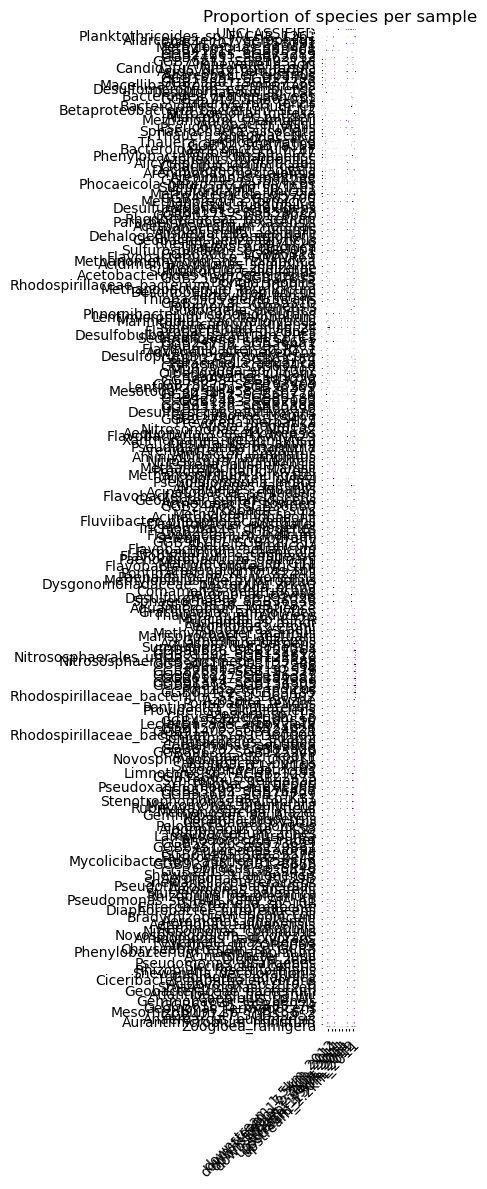

,downstream_1.5km_2012,downstream_17.5km_2011,downstream_2.3km_2011,downstream_2.7km_2011,effluent_point_2011,upstream_1.9km_2011,upstream_150m_2012,upstream_2.2km_2011
clade_name,,,,,,,,
UNCLASSIFIED,92.609100,98.599950,97.334050,98.110410,96.755020,98.167200,88.277040,94.854580
Planktothricoides_sp_FACHB_1261,4.993868,0.000000,0.000721,0.017372,0.015698,0.033083,9.159325,0.015480
Aliarcobacter_cryaerophilus,0.518840,0.034597,0.039729,0.123864,0.312124,0.211597,0.562859,0.472879
GGB41707_SGB58791,0.478770,0.001396,0.081815,0.019514,0.104623,0.002247,0.059514,0.290467
Methylomonas_sp_MP1,0.178137,0.021976,0.001380,0.001984,0.017945,0.000486,0.141465,0.039458
...,...,...,...,...,...,...,...,...
Mesorhizobium_sp_YM1C_6_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000772
GGB42747_SGB59953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000663
Anaeroarcus_burkinensis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000588


In [9]:
#todo EXAMPLE; REMOVE

import matplotlib.pyplot as plt
import numpy as np

species = species_df.index # y axis
samples = species_df.columns # x axis
proportion = np.array(species_df) # value in cell

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
im = ax.imshow(proportion)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(samples)), labels=samples)
ax.set_yticks(np.arange(len(species)), labels=species)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(species)):
    for j in range(len(samples)):
        text = ax.text(j, i, proportion[i, j].round(2),
                       ha="center", va="center", color="w")

ax.set_title("Proportion of species per sample")
fig.tight_layout()
plt.show()

species_df

In [10]:
#ref: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib.pyplot as plt
import numpy as np

import matplotlib


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

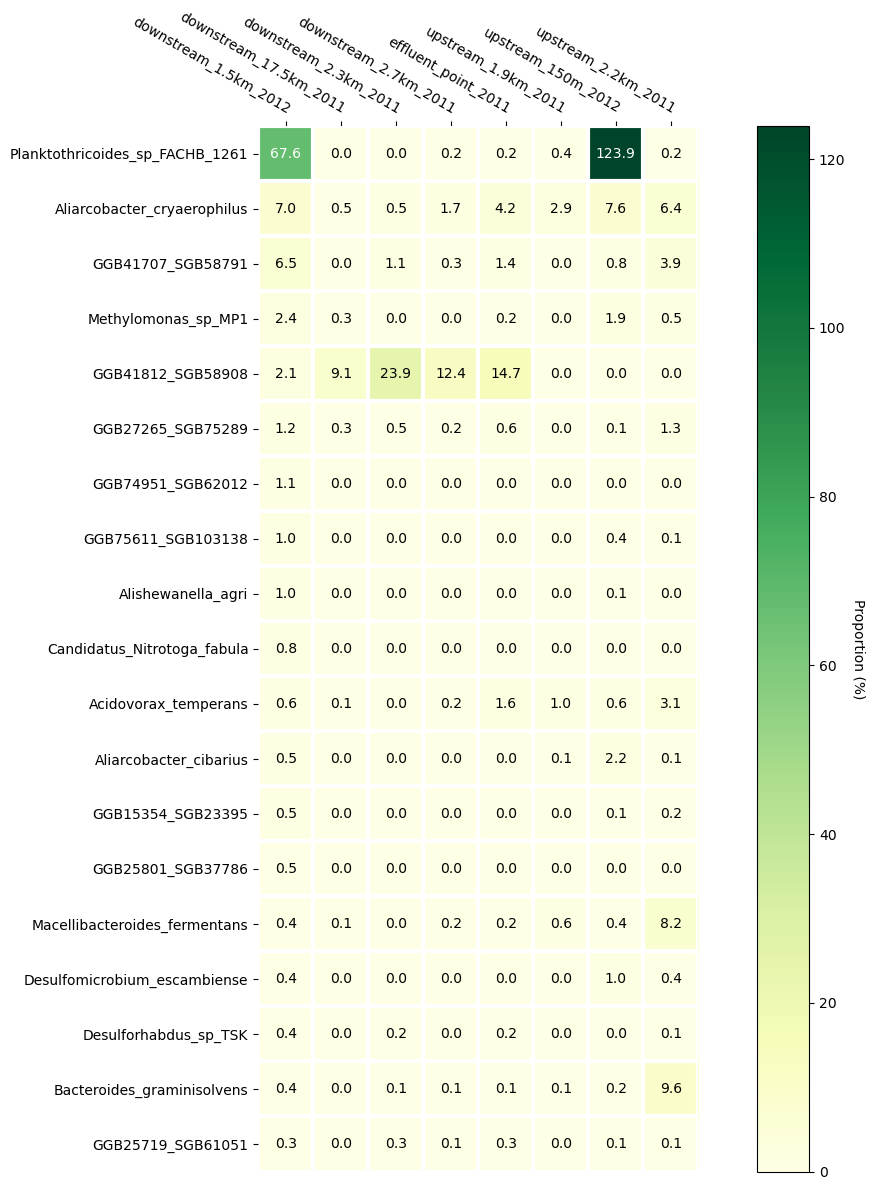

In [11]:
# Create the arrays for the functions to use
import matplotlib.pyplot as plt
import numpy as np

test_heatmap_df = test_df.iloc[1:20]

species = test_heatmap_df.index # y axis
samples = test_heatmap_df.columns # x axis
proportion = np.array(test_heatmap_df) # value in cell

#ref https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
plt.rcParams['figure.figsize'] = [12, 12]

fig, ax = plt.subplots()

im, cbar = heatmap(proportion, species, samples, ax=ax,
                   cmap="YlGn", cbarlabel="Proportion (%)")
texts = annotate_heatmap(im, valfmt="{x:.1f}") #todo Where the values are rounded 

fig.tight_layout()
plt.show()

In [13]:
%%bash
for file in `ls SRS*.txt`
do
echo $file
done


ls: cannot access 'SRS*.txt': No such file or directory


In [32]:
!all_profile_files=`ls *_profile.txt`
!$all_profile_files
#{species_files}
all_profile_files

NameError: name 'all_profile_files' is not defined

In [20]:
#PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
species_df

,downstream_1.5km_2012,downstream_17.5km_2011,downstream_2.3km_2011,downstream_2.7km_2011,effluent_point_2011,upstream_1.9km_2011,upstream_150m_2012,upstream_2.2km_2011
clade_name,,,,,,,,
UNCLASSIFIED,92.609100,98.599950,97.334050,98.110410,96.755020,98.167200,88.277040,94.854580
Planktothricoides_sp_FACHB_1261,4.993868,0.000000,0.000721,0.017372,0.015698,0.033083,9.159325,0.015480
Aliarcobacter_cryaerophilus,0.518840,0.034597,0.039729,0.123864,0.312124,0.211597,0.562859,0.472879
GGB41707_SGB58791,0.478770,0.001396,0.081815,0.019514,0.104623,0.002247,0.059514,0.290467
Methylomonas_sp_MP1,0.178137,0.021976,0.001380,0.001984,0.017945,0.000486,0.141465,0.039458
...,...,...,...,...,...,...,...,...
Mesorhizobium_sp_YM1C_6_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000772
GGB42747_SGB59953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000663
Anaeroarcus_burkinensis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000588


In [ ]:
sns.pairplot(species_df, hue='upstream_2.2km_2011')
#seaborn.pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)